In [18]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import time
import random

In [19]:
def initialize_tensor_network(graph_structure, tensors):
    """
    Initialize tensor network structure and validate consistency.
    
    Args:
        graph_structure: nx.Graph where edges represent tensor contractions
        tensors: Dict of {tensor_name: (array, [indices])}
                 e.g., {'A': (np.random.rand(3,3), ['i','j']), 
                        'B': (np.random.rand(3,3), ['j','k'])}
    
    Returns:
        Dictionary containing all network information
    """
    for u, v in graph_structure.edges():
        u_indices = set(tensors[u][1])
        v_indices = set(tensors[v][1])
        if not u_indices & v_indices:
            raise ValueError(f"Tensors {u} and {v} share no indices!")
    index_dims = {}
    for tensor_name, (array, indices) in tensors.items():
        for idx, size in zip(indices, array.shape):
            if idx in index_dims and index_dims[idx] != size:
                raise ValueError(f"Inconsistent dimension for index {idx}")
            index_dims[idx] = size
    neighbors = defaultdict(list)
    for u, v in graph_structure.edges():
        neighbors[u].append(v)
        neighbors[v].append(u)
    
    return {
        'graph': graph_structure,
        'tensors': tensors,
        'index_dims': index_dims,
        'neighbors': neighbors
    }

In [13]:
def evaluate_config(network, config):
    """Compute the product of all tensors for a given configuration."""
    value = 1.0
    for tensor_name, (array, indices) in network['tensors'].items():
        slice_tuple = tuple(config[idx] for idx in indices)
        value *= array[slice_tuple]
    return value

In [20]:
def update_index(network, config, index_to_update):
    """
    Update one index using Glauber dynamics.
    Only affects tensors that use this index.
    """
    # Find all tensors that use this index
    dependent_tensors = []
    for tensor_name, (_, indices) in network['tensors'].items():
        if index_to_update in indices:
            dependent_tensors.append(tensor_name)
    
    # Compute conditional distribution
    vals = []
    for idx_val in range(network['index_dims'][index_to_update]):
        new_config = config.copy()
        new_config[index_to_update] = idx_val
        vals.append(evaluate_config(network, new_config))
    
    # Normalize and sample
    probs = np.array(vals) / np.sum(vals)
    new_val = np.random.choice(np.arange(network['index_dims'][index_to_update]), p=probs)
    return new_val


In [15]:
def mcmc_trace(network, iters=10000, discards=1000):
    """Estimate the full contraction value of the tensor network."""
    tensors = network['tensors']
    dims = network['index_dims']
    index_to_tensors = defaultdict(list)
    
    for name, (array, indices) in tensors.items():
        for idx in indices:
            index_to_tensors[idx].append((name, array, indices))
    
    config = {idx: np.random.randint(0, dim) for idx, dim in dims.items()}
    samples = np.zeros(iters - discards)
    
    for t in range(iters):
        idx = np.random.choice(list(dims.keys()))
        
        vals = np.ones(dims[idx])
        for name, array, indices in index_to_tensors[idx]:
            idx_pos = indices.index(idx)
            other_indices = [config[i] for i in indices if i != idx]
            
            if idx_pos == 0:
                vals *= array[:, other_indices[0]]
            elif idx_pos == 1:
                vals *= array[other_indices[0], :]
            
        
        config[idx] = np.random.choice(np.arange(dims[idx]), p=vals/vals.sum())
        
        if t >= discards:
            samples[t-discards] = evaluate_config(network, config)
    
    return np.mean(samples) * np.prod(list(dims.values()))

def exact_trace(A, B, C, D):
    # compute the exact trace of the tensor network contraction
    return np.einsum('ij,jk,kl,li->', A, B, C, D)

def partial_contraction(network, fixed_indices, iters=10000, discards=1000):
    """
    Compute contraction with some indices fixed (open legs).
    fixed_indices: Dict of {index_name: fixed_value}
    """
    # Create reduced config space
    free_indices = {k: v for k, v in network['index_dims'].items() 
                   if k not in fixed_indices}
    
    # Initialize config (fixed + random free)
    config = fixed_indices.copy()
    config.update({idx: np.random.randint(0, dim) 
                  for idx, dim in free_indices.items()})
    
    # Run MCMC on free indices only
    samples = []
    for t in range(iters):
        idx_to_update = np.random.choice(list(free_indices.keys()))
        config[idx_to_update] = update_index(network, config, idx_to_update)
        
        if t >= discards:
            samples.append(evaluate_config(network, config))
    
    scaling = np.prod(list(free_indices.values()))
    return np.mean(samples) * scaling

In [21]:
def run_trials(dim_combos, iters=10000, discards=1000):
    results = {
        'dimensions': [],
        'mc_estimates': [],
        'exact_values': [],
        'errors': [],
        'runtimes': []
    }
    
    for dims in dim_combos:
        n_i, n_j, n_k, n_l = dims
        
        # Create cycle network
        G = nx.Graph([('A','B'), ('B','C'), ('C','D'), ('D','A')])
        
        # Generate tensors with different dimensions
        A = np.abs(np.random.randn(n_i, n_j))
        B = np.abs(np.random.randn(n_j, n_k))
        C = np.abs(np.random.randn(n_k, n_l))
        D = np.abs(np.random.randn(n_l, n_i))
        
        tensors = {
            'A': (A, ['i','j']),
            'B': (B, ['j','k']),
            'C': (C, ['k','l']),
            'D': (D, ['l','i'])
        }
        
        try:
            network = initialize_tensor_network(G, tensors)
            ex_trace = np.einsum('ij,jk,kl,li->', A, B, C, D)
            
            start = time.time()
            mc_trace = mcmc_trace(network, iters=iters, discards=discards)
            runtime = time.time() - start
            
            error = np.abs(mc_trace - ex_trace)
            
            # Store results
            results['dimensions'].append(dims)
            results['mc_estimates'].append(mc_trace)
            results['exact_values'].append(ex_trace)
            results['errors'].append(error)
            results['runtimes'].append(runtime)
            
            print(f"Dims (i,j,k,l)={dims}:")
            print(f"  Exact={ex_trace:.4f}, MC={mc_trace:.4f}")
            print(f"  Error={error:.4f}, Time={runtime:.4f}s\n")
            
        except ValueError as e:
            print(f"Failed for dims {dims}: {str(e)}")
            results['dimensions'].append(dims)
            results['mc_estimates'].append(np.nan)
            results['exact_values'].append(np.nan)
            results['errors'].append(np.nan)
            results['runtimes'].append(np.nan)

    return results


Dims (i,j,k,l)=(128, 2, 16, 8):
  Exact=13372.5525, MC=72076.7613
  Error=58704.2088, Time=5.1514s

Dims (i,j,k,l)=(8, 128, 16, 64):
  Exact=448673.6170, MC=2673437.8845
  Error=2224764.2675, Time=4.8254s

Dims (i,j,k,l)=(4, 64, 2, 8):
  Exact=1218.8363, MC=7077.5462
  Error=5858.7099, Time=4.9132s

Dims (i,j,k,l)=(32, 8, 64, 128):
  Exact=780567.5375, MC=5187098.0140
  Error=4406530.4765, Time=5.0294s

Dims (i,j,k,l)=(128, 64, 32, 8):
  Exact=777538.3608, MC=5232761.9558
  Error=4455223.5950, Time=4.8440s

Dims (i,j,k,l)=(16, 64, 32, 2):
  Exact=25497.4071, MC=150658.4138
  Error=125161.0067, Time=4.9575s

Dims (i,j,k,l)=(64, 2, 16, 4):
  Exact=2703.3062, MC=24344.4986
  Error=21641.1924, Time=4.8359s

Dims (i,j,k,l)=(4, 2, 64, 8):
  Exact=1092.6796, MC=6281.6652
  Error=5188.9856, Time=5.0693s

Dims (i,j,k,l)=(8, 128, 4, 2):
  Exact=3030.0600, MC=14463.8143
  Error=11433.7543, Time=5.1179s

Dims (i,j,k,l)=(16, 2, 4, 32):
  Exact=1592.6455, MC=6474.7724
  Error=4882.1269, Time=5.3790s

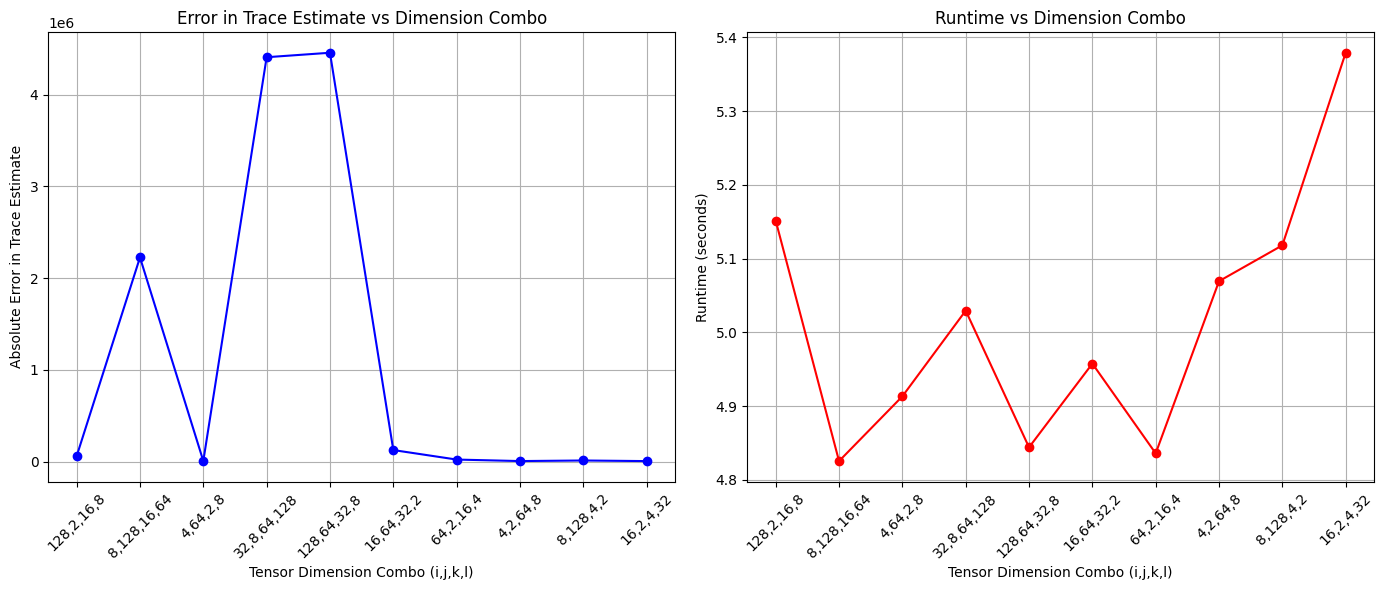

In [ ]:
dimensions = [2, 4, 8, 16, 32, 64, 128]

num_trials = 10
dim_combos = [tuple(random.sample(dimensions, 4)) for _ in range(num_trials)]

results = run_trials(dim_combos, iters=100000, discards=1000)

errors = results['errors']
runtimes = results['runtimes']
labels = [f"{d[0]},{d[1]},{d[2]},{d[3]}" for d in results['dimensions']]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(labels, errors, marker='o', linestyle='-', color='blue')
plt.xticks(rotation=45)
plt.xlabel('Tensor Dimension Combo (i,j,k,l)')
plt.ylabel('Absolute Error in Trace Estimate')
plt.title('Error in Trace Estimate vs Dimension Combo')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(labels, runtimes, marker='o', linestyle='-', color='red')
plt.xticks(rotation=45)
plt.xlabel('Tensor Dimension Combo (i,j,k,l)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs Dimension Combo')
plt.grid(True)

plt.tight_layout()
plt.show()